In [ ]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import * 
from src.stop_codon import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# arf1_df = pd.read_csv('../data/arf1_duplicates.csv', index_col=0) # The duplicates DataFrame contains both aRF1s from the genomes which had duplicate hits. 
# build_stop_codon_dataset(arf1_df, path='../data/arf1_duplicates_with_stop_codons.csv')

arf1_df = pd.read_csv('../data/arf1_duplicates_with_stop_codons.csv', index_col=0) # The duplicates DataFrame contains both aRF1s from the genomes which had duplicate hits. 

stop_codon_genome_metadata_df = pd.read_csv('../data/stop_codon_genome_metadata.csv', index_col=0)
arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count

if 'genome_gc_percent' not in arf1_df.columns:
    genome_gc_percents = {row.genome_id:FASTAFile().from_fasta(row.fn_path).get_gc_content() for row in arf1_df.drop_duplicates('genome_id').itertuples()}
    arf1_df['genome_gc_percent'] = arf1_df.genome_id.map(genome_gc_percents)

# Going to assume that the release factor with a slightly higher E-value is the aRF1. 
arf1_type_map = dict()
for _, df in arf1_df.groupby('genome_id'):
    df = df.sort_values('e_value')
    arf1_type_map[df.index.values[0]] = 1
    arf1_type_map[df.index.values[1]] = 2
arf1_df['arf1_type'] = arf1_df.index.map(arf1_type_map)


In [72]:
arf1_df.order.value_counts()

order
Methanosarcinales     60
Bathyarchaeales        8
Methanomicrobiales     6
UBA202                 4
Nitrososphaerales      4
UBA184                 4
Njordarchaeales        2
Methanotrichales       2
Halobacteriales        2
QMWL01                 2
Nezhaarchaeales        2
Micrarchaeales         2
Name: count, dtype: int64

<Axes: xlabel='genome_gc_percent', ylabel='tag_percent'>

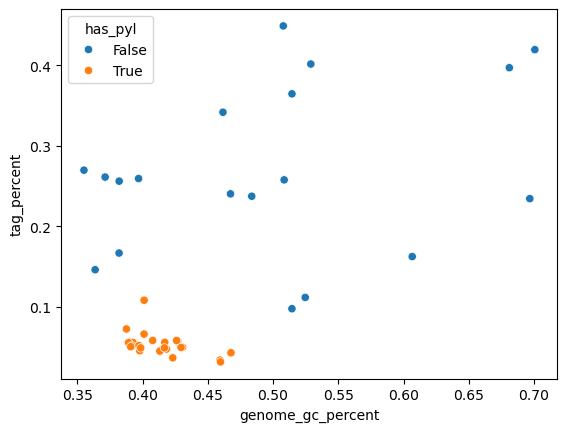

In [ ]:
arf1_df[arf1_df.has_pyl] #.stop_codon.value_counts()
# How to visualize this? Want to compare GC content and overall TAG percent, which can be connected. 
# Basically asking if organisms which use Pyl preferentially have aRF1-2s with a TAG stop codon. 

figure_df = arf1_df.drop_duplicates('genome_id')
sns.scatterplot(figure_df, x='genome_gc_percent', y='tag_percent', hue='has_pyl')

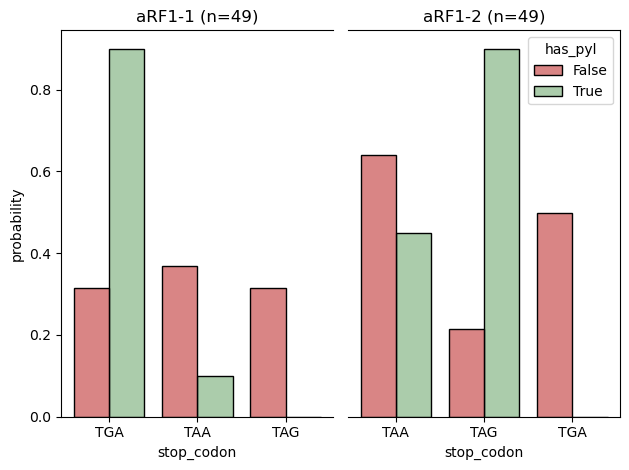

In [81]:
fig, (ax_a, ax_b) = plt.subplots(ncols=2)
figure_df = arf1_df.copy()

palette = {True:'darkseagreen', False:'indianred'}
stat = 'probability'
# order = ['TAG', 'TGA', 'TAA']
kwargs = {'multiple':'dodge', 'stat':stat, 'shrink':0.8, 'common_norm':False, 'palette':palette} # , 'order':order}
sns.histplot(figure_df[figure_df.arf1_type == 1], ax=ax_a, x='stop_codon', hue='has_pyl', legend=False, **kwargs)
sns.histplot(figure_df[figure_df.arf1_type == 2], ax=ax_b, x='stop_codon', legend=True, hue='has_pyl', **kwargs)

ax_a.spines.get('right').set_visible(False)
ax_b.spines.get('left').set_visible(False)
ax_b.set_ylabel('')
ax_b.set_yticks([])
ax_a.set_ylabel(stat)

ax_a.set_title(f'aRF1-1 (n={(figure_df.arf1_type == 1).sum()})')
ax_b.set_title(f'aRF1-2 (n={(figure_df.arf1_type == 2).sum()})')

fig.tight_layout()
plt.show()

# Worth noting that Pyl+ genomes tend to have lower GC content, which means they should be biased towards 
# TAA stop codons. That makes this especially weird. 

In [ ]:
seq = ''.join(alignment[0]) # The first entry in the alignment has the canonical NIKS domain and YXCXXXF.

niks_match = re.search('NIKS', seq)
# ycf_match = re.search(ycf_domain, seq, flags=re.DOTALL)

start, stop = niks_match.start(), niks_match.end()

In [ ]:
seq

'MTEAHEKYEFKKKLESLRDKKGRSTELISLYIPADKQIFDVTNQLKDEHGQAANIKSKLTRTNVQGAIESLLSRLRYLDKVPENGIVYFTGAVDIGANKTSMESEVIIPPEPITVYKYHCDSSFYLEPLEDMLKDKSTFGLLVLDRREATIGLLVGKRIQAFRNLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDAASEIFMAVHKDLKGVLIGGPSPTKEEFYGGEFLHHELQKKILGLFDTAYTDESGLSELVNAAGEKLQDLELMGQKNAVRDFFKELIADSGKVAYGETQVRANLEINAVDVLLLSEDLRAERVTTKCSVCGYENKWTRRWKPGEPAPTAGNCPKCGSSLEVTDVIDVVDEFSELADKSNAKVVFVSTDFDEGSQLMNAFGGIAAILRYSTGV*'

In [ ]:
# domain = 'niks'

# def figure(arf1_df:pd.DataFrame, domain:str='niks'):
#     fig, (ax_top, ax_bottom) = get_split_figure((0, 500), (2200, 2400))

#     # figure_df = pd.DataFrame(index=pd.Series(np.arange(1, 4), name='num_arf1'))
#     figure_df = list()

#     categories = ['pyl', f'pyl_{domain}', 'no_pyl', f'no_pyl_{domain}']
#     masks = [(arf1_df.has_pyl), (arf1_df.has_pyl & arf1_df[f'has_{domain}_domain']), (~arf1_df.has_pyl), (~arf1_df.has_pyl & arf1_df[f'has_{domain}_domain'])]
#     palette = {'pyl':'darkseagreen', f'pyl_{domain}':'seagreen', 'no_pyl':'indianred', f'no_pyl_{domain}':'firebrick'}

#     for category, mask in zip(categories, masks):
#         num_arf1_counts = arf1_df[mask].groupby('genome_id').size().value_counts()
#         figure_df += [{'num_arf1':n, 'count':num_arf1_counts.loc[n], 'category':category} for n in num_arf1_counts.index]
#     figure_df = pd.DataFrame(figure_df)
#     figure_df = figure_df[figure_df.num_arf1 < 4].copy()

#     # How many cases of Pyl-containing organisms with two ARF-1s and only one with a NIKS domain?
#     arf1_counts = arf1_df.groupby('genome_id').size()
#     genome_ids_multiple_arf1s = arf1_counts[arf1_counts > 1].index.values.tolist()
#     # no_pyl_genome_ids_multiple_arf1s = arf1_counts[(arf1_counts > 1) & (arf1_counts.index.isin(no_pyl_genome_ids))].index.values.tolist()

#     sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_top, palette=palette) #, binsize=0.2)
#     sns.barplot(figure_df, x='num_arf1', y='count', hue='category', edgecolor='black', ax=ax_bottom, legend=False, palette=palette) #, binsize=0.2)
#     ax_top.set_ylabel('')
#     ax_top.get_legend().set_title('')
#     ax_bottom.set_xlabel('num. aRF-1')

#     plt.show()
#     return genome_ids_multiple_arf1s

# genome_ids_multiple_arf1s = figure(arf1_df)
# arf1_df['has_multiple_arf1'] = arf1_df.genome_id.isin(genome_ids_multiple_arf1s)


# # It's concerning that some of the non-Pyl organisms have multiple aRF-1 genes. None of the non-Pyl genomes with multiple
# # aRF-1s have a lot of contamination, so it's possible that they have Pyl machinery that were missed by the HMMs.